## ARIMA: Autoregressive Integrated Moving Average Model

[Reference](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

* AR: *Autoregression*. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: *Integrated*. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: *Moving Average*. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

### EPM time series dataset

In [1]:
# Python Libraries 
import sys # System-specific parameters and functions 
import importlib # Implementation of python "import" statement 
import os
import ctedefs # another python file imported as module 
import datetime as dt # Date/Time functions
import pandas as pd # Pandas dataframe manipulation 
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from matplotlib import pyplot # plot the data
from pandas import DataFrame
from pathlib import Path # directory path manipulation
from sqlalchemy import create_engine # RDBMS integration w/ Pandas
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# Pull value of USERPROFILE form environment variables
userprofile_dir = Path(os.environ['USERPROFILE'])  
# Dynamically load $USERPROFILE/connection.py
connection_module = 'connection'
sys.path.append(str(userprofile_dir))
connection = importlib.import_module(connection_module)
sys.path.remove(str(userprofile_dir))

In [3]:
# Connect to EPM
# The call to connection.epm() to build connection string
engine = create_engine(connection.epm())
con = engine.connect()

In [4]:
# Run a test query - experiment with try/except around database calls
try:
  df_test = pd.read_sql('select 1 as cnt from dual', con)
except:
  print('EPM Connection Test exception')
  raise # reraise the exception - this will stop execution with a stack trace
else:
  if (df_test['cnt'][0] == 1):
    result = 'success'
  else:
    result = 'failure'
  print('EPM Connection Test: ' + result) # iterate through the past 12 months 

EPM Connection Test: success


In [5]:
cumulativeDf = pd.DataFrame() 

# *** SOLUTION to create a time series in python 
end_dt = pd.Timestamp(dt.datetime.now())   # current timestamp
end_dt = end_dt.replace(day=1,hour=0,minute=0,second=0,microsecond=0)  # midnight first day of current month
offset = -49     # number of previous time periods - note the negative sign for going back in time

# current time offset months previous
start_dt = (pd.Timestamp(dt.datetime.now()) + pd.DateOffset(months=offset))   
# midnight of first day of offset months previous
start_dt = start_dt.replace(day=1,hour=0,minute=0,second=0,microsecond=0)   
# create a list of month start dates, values for freq= are in pandas documentation
dateList = pd.date_range(start=start_dt, end=end_dt, freq='MS')    

# convert the timestamp series to string format series 
dateList = dateList.astype(str)

In [6]:
for date in dateList:
        numEmplDf = pd.read_sql(ctedefs.active_empl_cte.query_full().replace("CURRENT_DATE", date), con)
        cumulativeDf = cumulativeDf.append(numEmplDf)

In [7]:
cumulativeDf

monthdate  numofempl
0  2015-04-01      40645
0  2015-05-01      40803
0  2015-06-01      38170
0  2015-07-01      38146
0  2015-08-01      37451
0  2015-09-01      39095
0  2015-10-01      39540
0  2015-11-01      39641
0  2015-12-01      39774
0  2016-01-01      38876
0  2016-02-01      39409
0  2016-03-01      39676
0  2016-04-01      39752
0  2016-05-01      39835
0  2016-06-01      37940
0  2016-07-01      38245
0  2016-08-01      37802
0  2016-09-01      38870
0  2016-10-01      39324
0  2016-11-01      39704
0  2016-12-01      39889
0  2017-01-01      38928
0  2017-02-01      39698
0  2017-03-01      40017
0  2017-04-01      40176
0  2017-05-01      40329
0  2017-06-01      38407
0  2017-07-01      38614
0  2017-08-01      38464
0  2017-09-01      39229
0  2017-10-01      40196
0  2017-11-01      40523
0  2017-12-01      40722
0  2018-01-01      39778
0  2018-02-01      40471
0  2018-03-01      40922
0  2018-04-01      41128
0  2018-05-01      41338
0  2018-06-01      39259
0  2018-07-01      39619
0  2018-08-01      39352
0  2018-09-01      40196
0  2018-10-01      40956
0  2018-11-01      41301
0  2018-12-01      41403
0  2019-01-01      40547
0  2019-02-01      41301
0  2019-03-01      41835
0  2019-04-01      41929
0  2019-05-01      42073

In [8]:
# reset the index 
cumulativeDf = cumulativeDf.reset_index(drop=True)

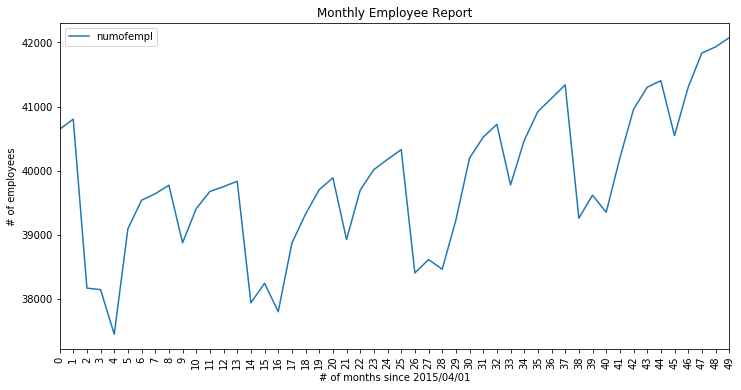

In [9]:
# set the figure size 
plt.figure(figsize=(12,6))

# plot the # of employees report over the past 50 months
ax = cumulativeDf.plot(xticks=cumulativeDf.index, title='Monthly Employee Report', rot=90, ax = plt.gca())
ax = ax.set(xlabel="# of months since 2015/04/01", ylabel="# of employees")

### ARIMA with Python

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters.
The model is prepared on the training data by calling the fit() function.
Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [10]:
# fit model 
model = ARIMA(cumulativeDf.numofempl, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.numofempl   No. Observations:                   49
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -381.826
Method:                       css-mle   S.D. of innovations            565.953
Date:                Thu, 30 May 2019   AIC                            777.652
Time:                        16:38:38   BIC                            790.894
Sample:                             1   HQIC                           782.676
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                41.9634     57.129      0.735      0.467     -70.006     153.933
ar.L1.D.numofempl    -0.0816      0.129     -0.635      0.529      -0.334       0.170
ar.L2.D.numofempl     0.

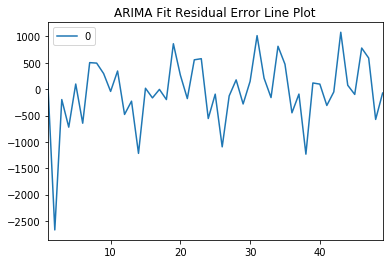

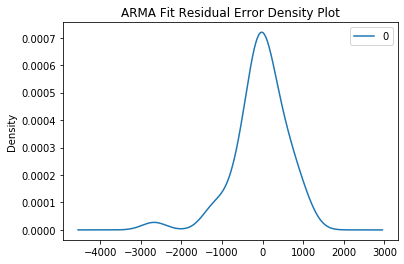

                 0
count    49.000000
mean    -46.148542
std     645.634272
min   -2669.235051
25%    -228.021311
50%     -43.091231
75%     295.260972
max    1078.705220


In [11]:
# plot residual errors 
residuals = DataFrame(model_fit.resid)
residuals.plot(title="ARIMA Fit Residual Error Line Plot")
pyplot.show()
residuals.plot(kind='kde', title="ARMA Fit Residual Error Density Plot")
pyplot.show()
print(residuals.describe())